# Chapter 3 — Discrete Distributions Explorer

A part of the *“Mastering Statistics in Python”* series by Pranav Alok

This notebook explores major discrete probability distributions — Binomial, Poisson, Geometric, Negative Binomial, and Hypergeometric — through theory, simulation, and visualization.

We also demonstrate Chebyshev’s Theorem, showing how probabilities concentrate around the mean for any finite-variance distribution.

## 1. Introduction

A discrete random variable takes on countable values (0, 1, 2, …) each with an associated probability.
Such variables arise whenever we count the number of successes, events, or trials.

This notebook demonstrates how theoretical probability mass functions (PMFs) align with Monte Carlo simulation results, deepening intuition for each distribution’s shape, mean, and variance.

We will study:

- Binomial Distribution — number of successes in fixed trials
- Poisson Distribution — counts of rare events per interval
- Geometric Distribution — trials until first success
- Negative Binomial Distribution — trials until r-th success
- Hypergeometric Distribution — successes in draws without replacement
- Chebyshev’s Theorem — distribution-free spread bound

## 2. Setup and Imports

We begin by importing Python libraries required for simulation and visualization:

- numpy, pandas → numerical computations
- scipy.stats → theoretical PMFs
- matplotlib, seaborn → plots and styling

We also create data/ and outputs/ folders to store inputs and generated figures.

In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom, poisson, geom, nbinom, hypergeom
from math import ceil

In [45]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (9,5)
plt.rcParams['savefig.dpi'] = 150

In [46]:
def savefig(fig, fname):
    """Save figure to outputs/ and close it."""
    path = os.path.join('outputs', fname)
    fig.savefig(path, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved: {path}")

In [47]:
def plot_compare_pmf(x, pmf_theory, pmf_empirical, title, fname=None, xlabel='k'):
    """Plot theoretical PMF vs empirical probabilities."""
    fig, ax = plt.subplots(figsize=(9,5))
    ax.bar(x - 0.2, pmf_empirical, width=0.4, label='Empirical (sim)', alpha=0.85, color='orange')
    ax.plot(x + 0.2, pmf_theory, 'o-', color='steelblue', label='Theoretical PMF', linewidth=2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Probability')
    ax.set_title(title)
    ax.legend()
    if fname:
        savefig(fig, fname)
    else:
        plt.show()

In [48]:
def summary_stats(sim, theoretical_mean=None, theoretical_var=None):
    """Return a dict with empirical mean and var and compare to theory if provided."""
    emp_mean = sim.mean()
    emp_var = sim.var(ddof=0)
    result = {
        'emp_mean': emp_mean,
        'emp_var': emp_var,
        'theo_mean': theoretical_mean,
        'theo_var': theoretical_var
    }
    return result

In [49]:
TRIALS = 20000       # simulation trials for pmf comparisons
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## 3. Binomial Distribution  

### **Theory**  
Models the number of successes in n independent Bernoulli trials with success probability p:  

$$
P(X = k) = \binom{n}{k} p^k (1 - p)^{n - k}
$$
$$
E[X] = np, \quad Var[X] = np(1 - p)
$$


### **Simulation**  
Simulate many sequences of \(n\) trials and count successes to estimate empirical probabilities.  
Plot theoretical vs simulated PMFs to observe convergence as trial count increases (Law of Large Numbers).

In [50]:
n = 20
p = 0.3
x_bin = np.arange(0, n+1)

# Theoretical pmf
pmf_bin_theory = binom.pmf(x_bin, n, p)

# Simulation (vectorized)
sim_bin = np.random.binomial(n, p, size=TRIALS)
counts_bin = np.bincount(sim_bin, minlength=n+1)[:n+1]
pmf_bin_emp = counts_bin / counts_bin.sum()

# Plot & save
plot_compare_pmf(x_bin, pmf_bin_theory, pmf_bin_emp,
                 title=f'Binomial(n={n}, p={p}) — Theory vs Simulation (trials={TRIALS})',
                 fname='binomial_pmf.png', xlabel='k (successes)')

# Print mean/variance comparison
bin_summary = summary_stats(sim_bin, theoretical_mean=n*p, theoretical_var=n*p*(1-p))
print("Binomial summary:")
print(f" Empirical mean = {bin_summary['emp_mean']:.4f}, Empirical var = {bin_summary['emp_var']:.4f}")
print(f" Theoretical mean = {bin_summary['theo_mean']:.4f}, Theoretical var = {bin_summary['theo_var']:.4f}\n")

Saved: outputs\binomial_pmf.png
Binomial summary:
 Empirical mean = 5.9959, Empirical var = 4.1942
 Theoretical mean = 6.0000, Theoretical var = 4.2000



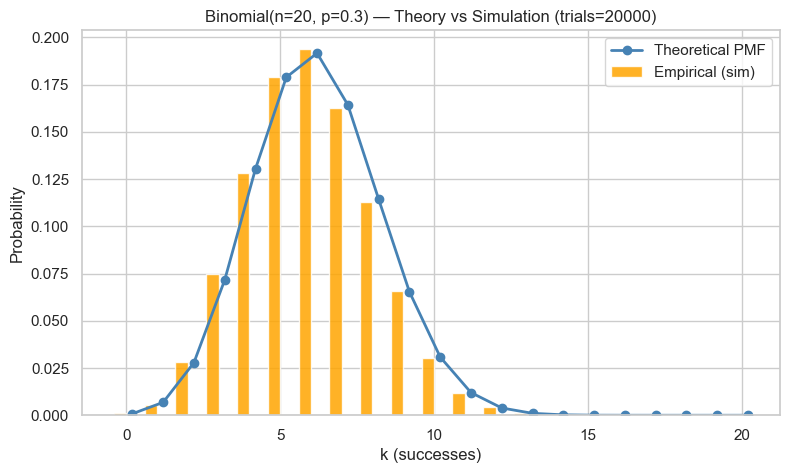

In [51]:
plot_compare_pmf(x_bin, pmf_bin_theory, pmf_bin_emp,
                 title=f'Binomial(n={n}, p={p}) — Theory vs Simulation (trials={TRIALS})',
                  xlabel='k (successes)')

## 4. Binomial — Parameter Sensitivity  

By varying p while keeping n fixed, we see how the distribution’s shape changes:  
- small \(p\) → right-skewed  
- large \(p\) → left-skewed  
- \(p=0.5\) → symmetric  

In [52]:
ps = [0.1, 0.3, 0.5, 0.8]
fig, ax = plt.subplots(figsize=(9,5))
for p_ in ps:
    ax.plot(x_bin, binom.pmf(x_bin, n, p_), 'o-', label=f'p={p_}')
ax.set_title(f'Binomial PMF for different p (n={n})')
ax.set_xlabel('k')
ax.set_ylabel('Probability')
ax.legend()
savefig(fig, 'binomial_sensitivity_p.png')

Saved: outputs\binomial_sensitivity_p.png


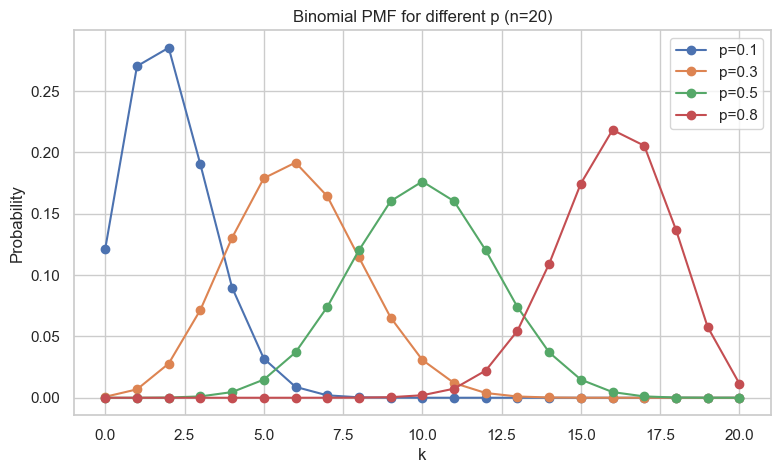

In [53]:
fig

## 5. Poisson Distribution  

### **Theory**  
Models the count of rare events in a fixed interval given average rate \(\lambda\):  

$$
P(X = k) = e^{-\lambda} \frac{\lambda^k}{k!}, \quad E[X] = Var[X] = \lambda
$$

### **Simulation**  
Generate Poisson counts using `np.random.poisson`.  
Compare empirical and theoretical PMFs and observe approximation to a bell shape as \(\lambda\) grows.

In [72]:
lam = 4.0
x_pois = np.arange(0, 20)

pmf_pois_theory = poisson.pmf(x_pois, lam)
sim_pois = np.random.poisson(lam, size=TRIALS)
counts_pois = np.bincount(sim_pois, minlength=x_pois.max()+1)[:len(x_pois)]
pmf_pois_emp = counts_pois / counts_pois.sum()

plot_compare_pmf(x_pois, pmf_pois_theory, pmf_pois_emp,
                 title=f'Poisson(λ={lam}) — Theory vs Simulation', fname='poisson_pmf.png', xlabel='k')

pois_summary = summary_stats(sim_pois, theoretical_mean=lam, theoretical_var=lam)
print("Poisson summary:")
print(f" Empirical mean = {pois_summary['emp_mean']:.4f}, Empirical var = {pois_summary['emp_var']:.4f}")
print(f" Theoretical mean = {pois_summary['theo_mean']:.4f}, Theoretical var = {pois_summary['theo_var']:.4f}\n")

Saved: outputs\poisson_pmf.png
Poisson summary:
 Empirical mean = 4.0190, Empirical var = 3.9909
 Theoretical mean = 4.0000, Theoretical var = 4.0000



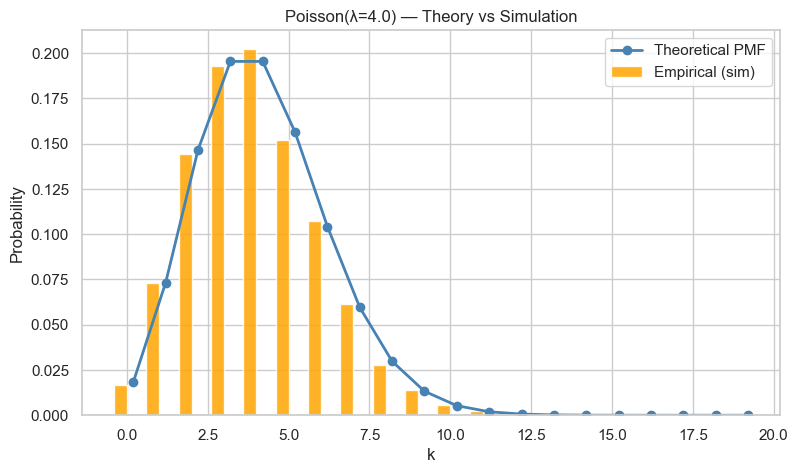

In [73]:
plot_compare_pmf(x_pois, pmf_pois_theory, pmf_pois_emp,
                 title=f'Poisson(λ={lam}) — Theory vs Simulation', xlabel='k')

## 6. Poisson — Effect of λ  

Plot PMFs for various λ values to illustrate:  
- small λ → highly skewed  
- large λ → nearly symmetric 

In [56]:
lams = [1, 4, 10]
fig, ax = plt.subplots(figsize=(9,5))
x_plot = np.arange(0, 30)
for L in lams:
    ax.plot(x_plot, poisson.pmf(x_plot, L), 'o-', label=f'λ={L}')
ax.set_title('Poisson PMF for different λ')
ax.set_xlabel('k')
ax.set_ylabel('Probability')
ax.legend()
savefig(fig, 'poisson_sensitivity_lambda.png')

Saved: outputs\poisson_sensitivity_lambda.png


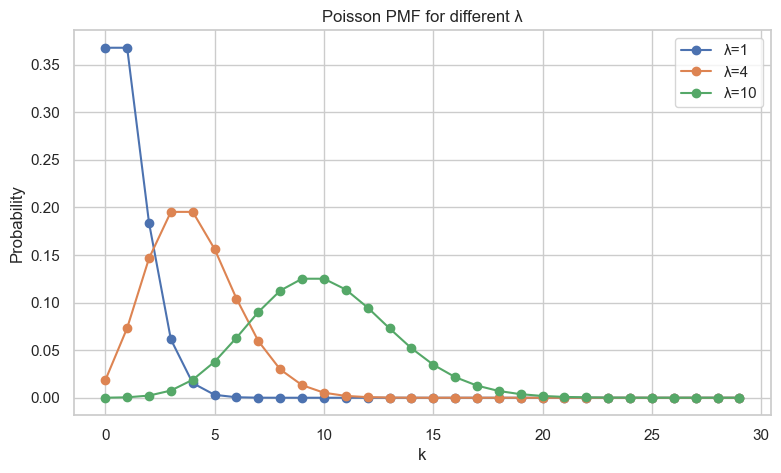

In [74]:
fig

## 7. Geometric Distribution  

### **Theory**  
Counts the number of trials until the first success:  

$$
P(X = k) = (1 - p)^{k - 1} p, \quad E[X] = \frac{1}{p}, \quad Var[X] = \frac{1 - p}{p^2}
$$


### **Simulation**  
Use `np.random.geometric(p)` to simulate waiting times and compare to theoretical PMF.  
Note the strong right skew and rapid decay of probability with larger \(k\).

In [58]:
p_geom = 0.25
trials_geom = TRIALS
x_geom = np.arange(1, 21)

pmf_geom_theory = geom.pmf(x_geom, p_geom)
sim_geom = np.random.geometric(p_geom, size=trials_geom)
# empirical pmf for 1..20
counts_geom = np.array([np.sum(sim_geom == k) for k in x_geom])
pmf_geom_emp = counts_geom / counts_geom.sum()

plot_compare_pmf(x_geom, pmf_geom_theory, pmf_geom_emp,
                 title=f'Geometric(p={p_geom}) — Theory vs Simulation',
                 fname='geometric_pmf.png', xlabel='k (trials until first success)')

geom_summary = summary_stats(sim_geom, theoretical_mean=1/p_geom, theoretical_var=(1-p_geom)/p_geom**2)
print("Geometric summary:")
print(f" Empirical mean = {geom_summary['emp_mean']:.4f}, Empirical var = {geom_summary['emp_var']:.4f}")
print(f" Theoretical mean = {geom_summary['theo_mean']:.4f}, Theoretical var = {geom_summary['theo_var']:.4f}\n")

Saved: outputs\geometric_pmf.png
Geometric summary:
 Empirical mean = 3.9989, Empirical var = 12.1036
 Theoretical mean = 4.0000, Theoretical var = 12.0000



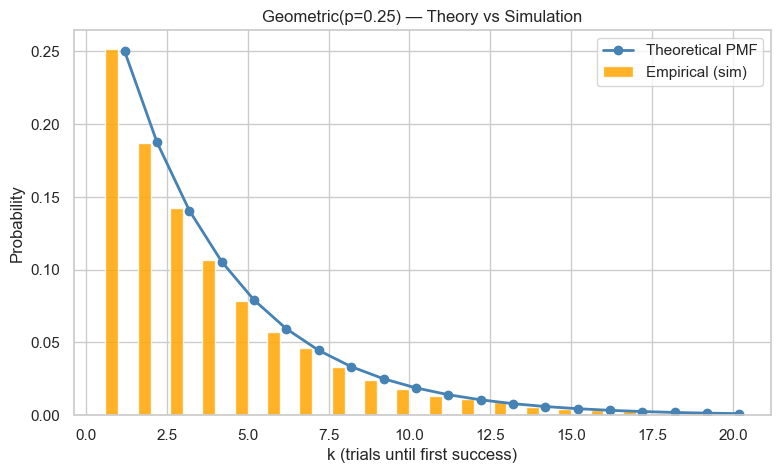

In [59]:
plot_compare_pmf(x_geom, pmf_geom_theory, pmf_geom_emp,
                 title=f'Geometric(p={p_geom}) — Theory vs Simulation',
                 xlabel='k (trials until first success)')

## 8. Negative Binomial Distribution  

### **Theory**  
Represents the number of trials needed to achieve the r-th success in independent Bernoulli trials:  

$$
P(X = k) = \binom{k - 1}{r - 1} p^r (1 - p)^{k - r}
$$
$$
E[X] = \frac{r}{p}, \quad Var[X] = \frac{r(1 - p)}{p^2}
$$

### **Interpretation**  
- \(r=1\) reduces to Geometric.  
- Larger \(r\) → more symmetric shape.  
- Models counts of failures before r successes or total trials until r-th success.

In [60]:
r = 5      # number of successes
p_nb = 0.3
# We'll plot distribution for number of trials until r-th success: k_trials = failures + r
k_fail = np.arange(0, 40)  # failures
pmf_nb_theory_fail = nbinom.pmf(k_fail, r, p_nb)  # scipy's nbinom: counts failures before r successes
# convert to trials = failures + r
k_trials = k_fail + r
# Simulation: numpy's negative_binomial returns number of failures before r successes
sim_nb_fail = np.random.negative_binomial(r, p_nb, size=TRIALS)
# Empirical pmf over failures
counts_nb_fail = np.bincount(sim_nb_fail, minlength=k_fail.max()+1)[:len(k_fail)]
pmf_nb_emp_fail = counts_nb_fail / counts_nb_fail.sum()

# Plot failures-PMF (theory vs empirical)
plot_compare_pmf(k_fail, pmf_nb_theory_fail, pmf_nb_emp_fail,
                 title=f'Negative Binomial (failures before r={r} successes), p={p_nb}',
                 fname='negative_binomial_failures_pmf.png', xlabel='k (failures)')

# Convert summary to trials if you prefer:
emp_trials = sim_nb_fail + r
theo_mean_trials = r / p_nb
theo_var_trials = r * (1 - p_nb) / (p_nb**2)
nb_summary = summary_stats(emp_trials, theoretical_mean=theo_mean_trials, theoretical_var=theo_var_trials)
print("Negative Binomial (trials until r-th success) summary:")
print(f" Empirical mean (trials) = {nb_summary['emp_mean']:.4f}, Empirical var = {nb_summary['emp_var']:.4f}")
print(f" Theoretical mean = {nb_summary['theo_mean']:.4f}, Theoretical var = {nb_summary['theo_var']:.4f}\n")

Saved: outputs\negative_binomial_failures_pmf.png
Negative Binomial (trials until r-th success) summary:
 Empirical mean (trials) = 16.6532, Empirical var = 38.6310
 Theoretical mean = 16.6667, Theoretical var = 38.8889



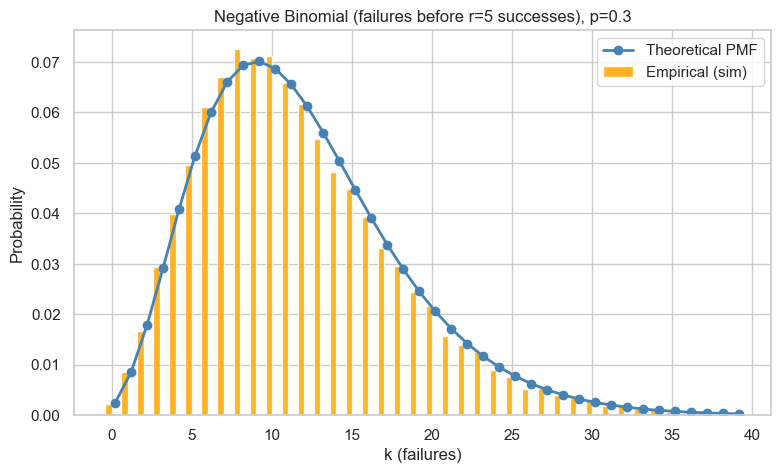

In [61]:
plot_compare_pmf(k_fail, pmf_nb_theory_fail, pmf_nb_emp_fail,
                 title=f'Negative Binomial (failures before r={r} successes), p={p_nb}',
                 xlabel='k (failures)')

## 9. Hypergeometric Distribution  

### **Theory**  
Models sampling **without replacement** from a finite population.  

Parameters:  
- \(N\): population size  
- \(K\): number of success items  
- \(n\): sample size  

$$
P(X = k) = \frac{\binom{K}{k}\binom{N - K}{n - k}}{\binom{N}{n}}
$$
$$
E[X] = n\frac{K}{N}, \quad Var[X] = n\frac{K}{N}\left(1 - \frac{K}{N}\right)\frac{N - n}{N - 1}
$$
 

### **Interpretation**  
Used for quality control, ecological sampling, and survey selection where sampling is without replacement.

In [62]:
N = 100   # population size
K = 20    # successes in population
n_draws = 15  # draws without replacement
x_hyper = np.arange(0, n_draws+1)

pmf_hyper_theory = hypergeom.pmf(x_hyper, N, K, n_draws)
# Simulation: numpy's hypergeometric signature: (ngood, nbad, nsample, size)
sim_hyper = np.random.hypergeometric(K, N-K, n_draws, size=TRIALS)
counts_hyper = np.bincount(sim_hyper, minlength=n_draws+1)[:len(x_hyper)]
pmf_hyper_emp = counts_hyper / counts_hyper.sum()

plot_compare_pmf(x_hyper, pmf_hyper_theory, pmf_hyper_emp,
                 title=f'Hypergeometric(N={N}, K={K}, n={n_draws}) — Theory vs Simulation',
                 fname='hypergeometric_pmf.png', xlabel='k (successes in sample)')

hyper_summary = summary_stats(sim_hyper, theoretical_mean=n_draws*(K/N),
                             theoretical_var=(n_draws*(K/N)*(1-K/N)*((N-n_draws)/(N-1))))
print("Hypergeometric summary:")
print(f" Empirical mean = {hyper_summary['emp_mean']:.4f}, Empirical var = {hyper_summary['emp_var']:.4f}")
print(f" Theoretical mean = {hyper_summary['theo_mean']:.4f}, Theoretical var = {hyper_summary['theo_var']:.4f}\n")

Saved: outputs\hypergeometric_pmf.png
Hypergeometric summary:
 Empirical mean = 2.9971, Empirical var = 2.0745
 Theoretical mean = 3.0000, Theoretical var = 2.0606



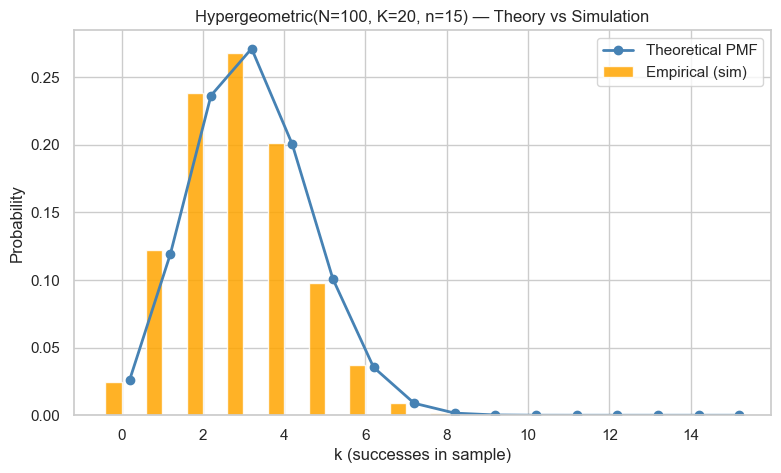

In [63]:
plot_compare_pmf(x_hyper, pmf_hyper_theory, pmf_hyper_emp,
                 title=f'Hypergeometric(N={N}, K={K}, n={n_draws}) — Theory vs Simulation',
                 xlabel='k (successes in sample)')

## 10. Chebyshev’s (The Chebyshev) Theorem Visualization  

### **Statement**  
For any random variable X with mean and finite standard deviation $$ \mu, \sigma :$$  

$$
P(|X - \mu| < k\sigma) \ge 1 - \frac{1}{k^2}, \quad k > 1
$$


This inequality applies to **any** distribution, not just Normal.  

### **Visualization Idea**  
1. Select a non-normal distribution (e.g., Geometric or Poisson).  
2. Plot histogram and mark intervals $$(\mu\pm k\sigma)$$ for k = 1.5, 2, 3.  
3. Compute actual proportion within each interval and compare with theoretical lower bound \(1-1/k^{2}\).  

The observed values should exceed the bound, showing that Chebyshev’s Theorem is a conservative guarantee.

In [64]:
def chebyshev_demo(data, ks=(1.5, 2, 3), title='Chebyshev Visualization', fname='chebyshev_demo.png'):
    mu = data.mean()
    sigma = data.std(ddof=0)
    fig, ax = plt.subplots(figsize=(9,5))
    # histogram
    sns.histplot(data, bins=30, stat='probability', color='lightgrey', edgecolor='black', ax=ax)
    # vertical lines and shaded intervals
    observed = {}
    for k in ks:
        lower = mu - k * sigma
        upper = mu + k * sigma
        # proportion within interval
        prop = np.mean((data > lower) & (data < upper))
        observed[k] = prop
        ax.axvline(lower, color='red', linestyle='--', alpha=0.7)
        ax.axvline(upper, color='red', linestyle='--', alpha=0.7)
        ax.fill_betweenx([0, ax.get_ylim()[1]], lower, upper, alpha=0.08)
        # annotate
        ax.text(upper, ax.get_ylim()[1]*0.9 - 0.05*k, f'k={k}: emp={prop:.3f}\nbound={1-1/k**2:.3f}', fontsize=9)
    ax.set_title(title + f' (μ={mu:.2f}, σ={sigma:.2f})')
    if fname:
        savefig(fig, fname)
    else:
        plt.show()
    return observed

# Use a non-normal distribution: geometric simulated data (from above)
cheb_obs = chebyshev_demo(sim_geom, ks=(1.5, 2, 3), title='Chebyshev on Geometric Distribution', fname='chebyshev_geometric.png')
print("Chebyshev observed proportions (geometric):")
for k,v in cheb_obs.items():
    print(f" k={k}: observed proportion within kσ = {v:.4f}, theoretical lower bound = {1 - 1/(k**2):.4f}")
print()

# Also try on Poisson
cheb_obs_pois = chebyshev_demo(sim_pois, ks=(1.5,2,3), title='Chebyshev on Poisson Distribution', fname='chebyshev_poisson.png')
print("Chebyshev observed proportions (poisson):")
for k,v in cheb_obs_pois.items():
    print(f" k={k}: observed proportion within kσ = {v:.4f}, theoretical lower bound = {1 - 1/(k**2):.4f}")
print()

Saved: outputs\chebyshev_geometric.png
Chebyshev observed proportions (geometric):
 k=1.5: observed proportion within kσ = 0.9250, theoretical lower bound = 0.5556
 k=2: observed proportion within kσ = 0.9426, theoretical lower bound = 0.7500
 k=3: observed proportion within kσ = 0.9817, theoretical lower bound = 0.8889

Saved: outputs\chebyshev_poisson.png
Chebyshev observed proportions (poisson):
 k=1.5: observed proportion within kσ = 0.7972, theoretical lower bound = 0.5556
 k=2: observed proportion within kσ = 0.9309, theoretical lower bound = 0.7500
 k=3: observed proportion within kσ = 0.9917, theoretical lower bound = 0.8889



In [ ]:
rows = []
rows.append({
    'Distribution': 'Binomial(n,p)',
    'Params': f'n={n}, p={p}',
    'Empirical mean': bin_summary['emp_mean'],
    'Theoretical mean': bin_summary['theo_mean'],
    'Empirical var': bin_summary['emp_var'],
    'Theoretical var': bin_summary['theo_var']
})
rows.append({
    'Distribution': 'Poisson(λ)',
    'Params': f'λ={lam}',
    'Empirical mean': pois_summary['emp_mean'],
    'Theoretical mean': pois_summary['theo_mean'],
    'Empirical var': pois_summary['emp_var'],
    'Theoretical var': pois_summary['theo_var']
})
rows.append({
    'Distribution': 'Geometric(p)',
    'Params': f'p={p_geom}',
    'Empirical mean': geom_summary['emp_mean'],
    'Theoretical mean': geom_summary['theo_mean'],
    'Empirical var': geom_summary['emp_var'],
    'Theoretical var': geom_summary['theo_var']
})
rows.append({
    'Distribution': 'NegativeBinomial (trials)',
    'Params': f'r={r}, p={p_nb}',
    'Empirical mean': nb_summary['emp_mean'],
    'Theoretical mean': nb_summary['theo_mean'],
    'Empirical var': nb_summary['emp_var'],
    'Theoretical var': nb_summary['theo_var']
})
rows.append({
    'Distribution': 'Hypergeometric',
    'Params': f'N={N}, K={K}, n={n_draws}',
    'Empirical mean': hyper_summary['emp_mean'],
    'Theoretical mean': hyper_summary['theo_mean'],
    'Empirical var': hyper_summary['emp_var'],
    'Theoretical var': hyper_summary['theo_var']
})

summary_df = pd.DataFrame(rows)
# round to four digits after decimal for prettier display
summary_df[['Empirical mean','Theoretical mean','Empirical var','Theoretical var']] = summary_df[
    ['Empirical mean','Theoretical mean','Empirical var','Theoretical var']].round(4)
print("Consolidated summary:")
display(summary_df)

# Save summary to CSV
summary_df.to_csv('outputs/discrete_distributions_summary.csv', index=False)
print("Saved summary CSV: outputs/discrete_distributions_summary.csv")

Consolidated summary:


,Distribution,Params,Empirical mean,Theoretical mean,Empirical var,Theoretical var
0,"Binomial(n,p)","n=20, p=0.3",5.9959,6.0000,4.1942,4.2000
1,Poisson(λ),λ=4.0,4.0002,4.0000,3.9894,4.0000
2,Geometric(p),p=0.25,3.9988,4.0000,12.1036,12.0000
3,NegativeBinomial (trials),"r=5, p=0.3",16.6532,16.6667,38.6310,38.8889
4,Hypergeometric,"N=100, K=20, n=15",2.9971,3.0000,2.0745,2.0606


Saved summary CSV: outputs/discrete_distributions_summary.csv
